# **Initialization**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

In [3]:
# Filepath init
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

# **Exercise 1**

In [4]:
# Install openpyxl if not already installed
%pip install openpyxl

# Extracting the data and formatting the dataset
monthly_return = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
monthly_return_melted = monthly_return.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
monthly_return_melted.rename(columns={'NAME': 'Name'}, inplace=True)

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Extracting the country-region dataset and merging it to the previous one
static = pd.read_excel(filepath + 'Static.xlsx')
df_ex1 = pd.merge(monthly_return_melted, static, on=['Name','ISIN'], how='outer')

In [6]:
# Filtering the rows of interest
df_ex1 = df_ex1[df_ex1['Region'] == 'PAC']
df_ex1 = df_ex1[(pd.to_datetime(df_ex1['year']) >= '2013-12-31') & (pd.to_datetime(df_ex1['year']) <= '2023-12-31')]

In [7]:
# Sorting to facilitate comprehension
df_ex1.sort_values(by=['Name', 'year'], inplace=True)

In [8]:
# New col with percentage change between two months
df_ex1['individual_monthly_return'] = df_ex1.groupby('Name')['monthly_return'].pct_change()

In [9]:
df_ex1

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
1074,77 BANK,JP3352000008,2013-12-31 00:00:00,0.68,JP,PAC,NaN
1075,77 BANK,JP3352000008,2014-01-31 00:00:00,0.66,JP,PAC,-0.029412
1076,77 BANK,JP3352000008,2014-02-28 00:00:00,0.62,JP,PAC,-0.060606
1077,77 BANK,JP3352000008,2014-03-31 00:00:00,0.64,JP,PAC,0.032258
1078,77 BANK,JP3352000008,2014-04-30 00:00:00,0.64,JP,PAC,0.000000
...,...,...,...,...,...,...,...
770389,YUEXIU PROPERTY COMPANY,HK0000745908,2023-08-31 00:00:00,62.82,HK,PAC,-0.055906
770390,YUEXIU PROPERTY COMPANY,HK0000745908,2023-09-29 00:00:00,58.43,HK,PAC,-0.069882
770391,YUEXIU PROPERTY COMPANY,HK0000745908,2023-10-31 00:00:00,54.23,HK,PAC,-0.071881
770392,YUEXIU PROPERTY COMPANY,HK0000745908,2023-11-30 00:00:00,47.52,HK,PAC,-0.123732


In [10]:
# Dropping the 31.12.2013 rows (not included in our timeframe but necessary for the pct_change of 31.12.2014)
df_ex1 = df_ex1[pd.to_datetime(df_ex1['year']).dt.year >= 2014]

In [11]:
# Filtering by non missing escores (2013-2024) complete dataset to allow comparisons
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')
melted_escore = escore.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="escore")
melted_escore.rename(columns={'NAME': 'Name'}, inplace=True)
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')
escore_interest = pd.merge(melted_escore, static, how='outer')
escore_interest = escore_interest[(escore_interest['year'] >= '2013-01-01') & (melted_escore['year'] <= '2024-12-31')]
escore_interest = escore_interest[escore_interest['Region'] == 'PAC']

In [12]:
filtered = escore_interest.groupby('ISIN')['escore'].count().reset_index()
filtered = filtered[filtered['escore'] == 11]

In [13]:
interest_companies = filtered['ISIN'].tolist()

In [14]:
# Filtering df_ex1 to include only non missing escores
df_ex1 = df_ex1[df_ex1['ISIN'].isin(interest_companies)]

In [15]:
df_ex1[df_ex1['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29 00:00:00,NaN,JP,PAC,0.0
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31 00:00:00,NaN,JP,PAC,0.0
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30 00:00:00,NaN,JP,PAC,0.0
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29 00:00:00,NaN,JP,PAC,0.0
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29 00:00:00,NaN,JP,PAC,0.0


In [16]:
# Individual handling of the 5 missings
df_ex1['individual_monthly_return'].loc[592512] = -1.
df_ex1['individual_monthly_return'].loc[592513] = np.nan
df_ex1['individual_monthly_return'].loc[592514] = np.nan
df_ex1['individual_monthly_return'].loc[592515] = np.nan
df_ex1['individual_monthly_return'].loc[698819] = -1.


In [17]:
# Creation of the averaged returns and their std + merge
annualization_mean = df_ex1.groupby('Name')['individual_monthly_return'].mean()
annualization_mean = pd.DataFrame(annualization_mean)
annualization_mean.rename(columns={'individual_monthly_return': 'monthly_mean'}, inplace=True)

annualization_var = df_ex1.groupby('Name')['individual_monthly_return'].std()
annualization_var = pd.DataFrame(annualization_var)
annualization_var.rename(columns={'individual_monthly_return': 'monthly_std'}, inplace=True)

annualization = pd.merge(annualization_mean, annualization_var, on='Name', how='outer')

In [18]:
# Creation of annualized cols
annualization['annualized_mean'] = annualization['monthly_mean'] * 12
annualization['annualized_std'] = annualization['monthly_std'] * np.sqrt(12)

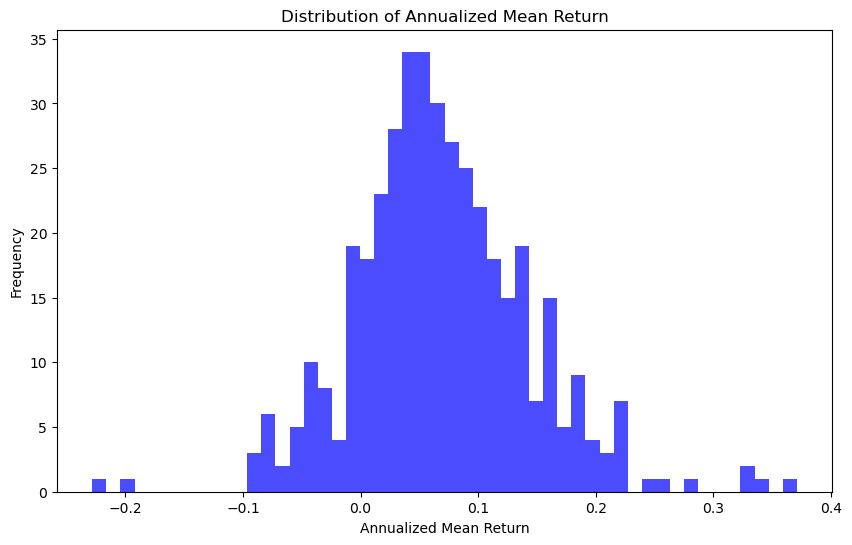

In [19]:
# Annualized mean histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_mean'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Mean Return')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Mean Return')
plt.show()

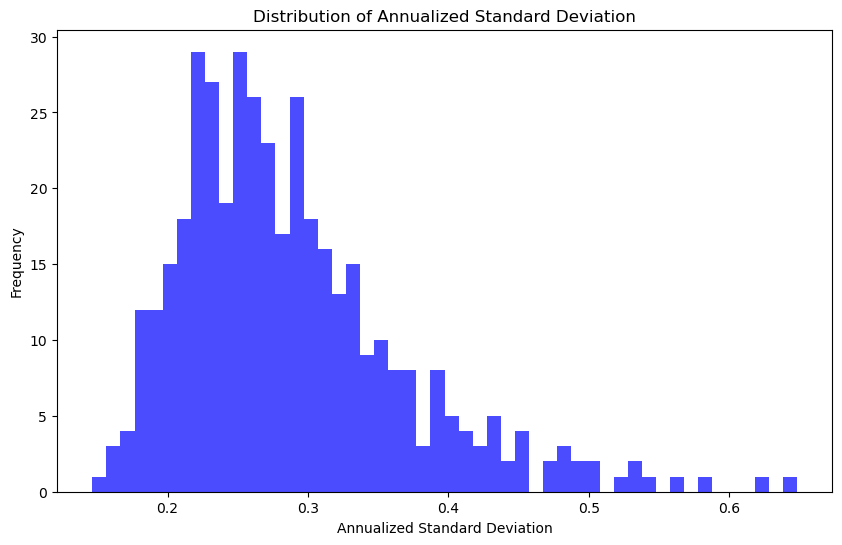

In [20]:
# Annualized std histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_std'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Standard Deviation')
plt.show()

In [21]:
# Variance-covariance matrix
np.corrcoef(annualization['annualized_mean'], annualization['annualized_std'])

array([[1.        , 0.08510139],
       [0.08510139, 1.        ]])

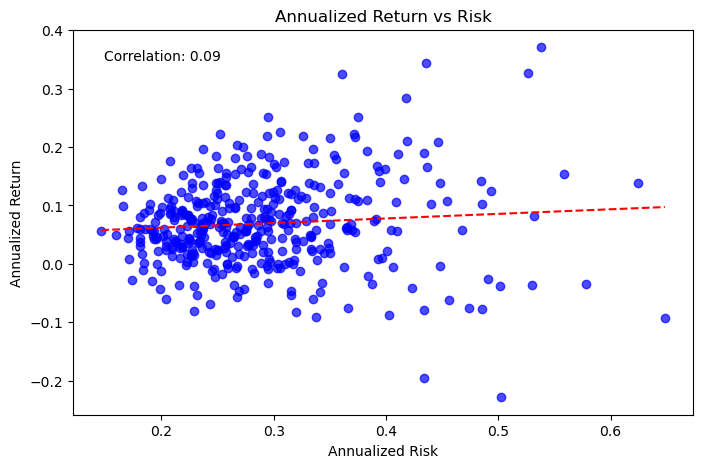

In [22]:
# Define annualized_returns DataFrame
annualized_returns = annualization[['annualized_std', 'annualized_mean']].rename(columns={'annualized_std': 'RISK', 'annualized_mean': 'RET_PCT'})

plt.figure(figsize=(8, 5))
plt.scatter(annualized_returns['RISK'], annualized_returns['RET_PCT'], color='blue', alpha=0.7)
plt.xlabel('Annualized Risk')
plt.ylabel('Annualized Return')
plt.title('Annualized Return vs Risk')

# Compute correlation
corr = annualized_returns['RISK'].corr(annualized_returns['RET_PCT'])

# Add a trendline
slope, intercept = np.polyfit(annualized_returns['RISK'], annualized_returns['RET_PCT'], 1)
x = np.linspace(annualized_returns['RISK'].min(), annualized_returns['RISK'].max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', linestyle='--', label='Trendline')

# Display correlation on the plot
plt.text(
    0.05, 0.95,
    f'Correlation: {corr:.2f}',
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top'
)

plt.show()

# **Exercise 2**

In [23]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')


In [24]:
# Risk-free rates dataset
risk_free = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')
risk_free.rename(columns={'Unnamed: 0': 'year'}, inplace=True)
risk_free['year'] = pd.to_datetime(risk_free['year'], format='%Y%m')

In [25]:
# Merging the datasets
df_ex2 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex2.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex2 = pd.merge(df_ex2, static, on=['Name', 'ISIN'], how='outer')

In [26]:
# Filter region and years of interest
df_ex2 = df_ex2[df_ex2['Region'] == 'PAC']
df_ex2 = df_ex2[(df_ex2['year'] >= '2013-12-31') & (df_ex2['year'] <= '2023-12-31')]
df_ex2['year'] = pd.to_datetime(df_ex2['year'])

In [27]:
# Filter same companies as in ex1 (non missing escores from 2013 to 2024)
df_ex2 = df_ex2[df_ex2['ISIN'].isin(interest_companies)]

In [28]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC


In [29]:
# Returns percentage change and drop the 31.12.2013 rows
df_ex2['pct_monthly_return'] = df_ex2.groupby('Name')['monthly_return'].pct_change()
df_ex2 = df_ex2[pd.to_datetime(df_ex2['year']).dt.year >= 2014]

In [30]:
# Individual handling of the 5 missings
df_ex2['pct_monthly_return'].loc[592512] = -1.
df_ex2['pct_monthly_return'].loc[592513] = np.nan
df_ex2['pct_monthly_return'].loc[592514] = np.nan
df_ex2['pct_monthly_return'].loc[592515] = np.nan
df_ex2['pct_monthly_return'].loc[698819] = -1.


In [31]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,pct_monthly_return
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,-1.0
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,NaN
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,NaN
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,NaN
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,-1.0


In [32]:
# Building the equally weighted portfolio
ew_pf = df_ex2.groupby('year')['pct_monthly_return'].sum().reset_index()

In [33]:
# Dividing the return by the number of assets for each month
ew_pf['ew_m_ret'] = 0
for month in df_ex2['year'].unique():
    ew_pf.loc[ew_pf['year'] == month, 'ew_m_ret'] = ew_pf.loc[ew_pf['year'] == month, 'pct_monthly_return'] / len(df_ex2[df_ex2['year'] == month]['Name'].unique())

In [34]:
# Calculate the market value share
df_ex2['mv_share'] = df_ex2['monthly_market_value'] / df_ex2.groupby('year')['monthly_market_value'].transform('sum')

In [35]:
# Weight the returns by the market value share shifted as in the exercise sheet
df_ex2['mv_return'] = df_ex2['pct_monthly_return'] * df_ex2['mv_share'].shift(1)

In [36]:
# Market value weighted portfolio
mw_pf = df_ex2.groupby('year')['mv_return'].sum().reset_index()

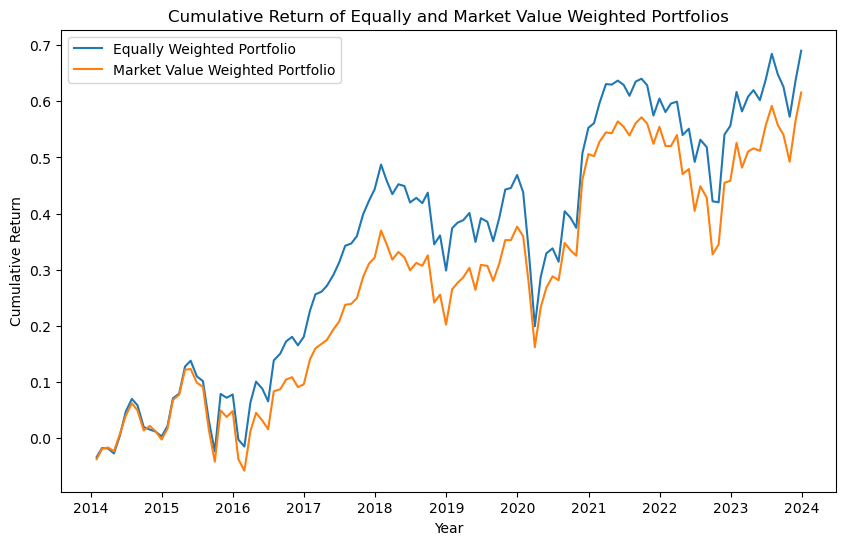

In [37]:
# Plot the monthly adapted returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(ew_pf['year'], ew_pf['ew_m_ret'].cumsum(), label='Equally Weighted Portfolio')
plt.plot(mw_pf['year'], mw_pf['mv_return'].cumsum(), label='Market Value Weighted Portfolio')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Equally and Market Value Weighted Portfolios')
plt.legend()
plt.show()

In [38]:
# Risk free rate in the given period 
risk_free = risk_free[(pd.to_datetime(risk_free['year']).dt.year >= 2014) & (pd.to_datetime(risk_free['year']).dt.year <= 2023)]
# Annualized risk free rate
ann_rf = risk_free['RF'].mean() * 12 / 100

In [39]:
# Statistics of interest Equally Weighted Portfolio
# Annualized return
ew_ann_ret = ew_pf['ew_m_ret'].mean() * 12
# Annualized std
ew_ann_std = ew_pf['ew_m_ret'].std() * np.sqrt(12)
#min return
ew_min_ret = ew_pf['ew_m_ret'].min()
#max return
ew_max_ret = ew_pf['ew_m_ret'].max()

# Statistics of interest Market Value Weighted Portfolio
# Annualized return
mw_ann_ret = mw_pf['mv_return'].mean() * 12
# Annualized std
mw_ann_std = mw_pf['mv_return'].std() * np.sqrt(12)
#min return
mw_min_ret = mw_pf['mv_return'].min()
#max return
mw_max_ret = mw_pf['mv_return'].max()


In [40]:
# Equally weighted Sharpe Ratio
ew_sharpe = (ew_ann_ret - ann_rf)/ ew_ann_std
ew_sharpe

0.38387887979603214

In [41]:
# Value weighted Sharpe Ratio
mw_sharpe = (mw_ann_ret - ann_rf)/ mw_ann_std
mw_sharpe


0.35568049703395765

In [42]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069011,0.149373,0.383879,-0.136916,0.132389
1,Market Value Weighted,0.061567,0.140286,0.355680,-0.115458,0.135156


In [43]:
'''delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
       'TOSHIBA DEAD - DELIST.20/12/23']'''

"delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',\n       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',\n       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',\n       'LAWSON DEAD - DELIST.24/07/24',\n       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',\n       'TOSHIBA DEAD - DELIST.20/12/23']"

In [44]:
annualization = annualization.reset_index()

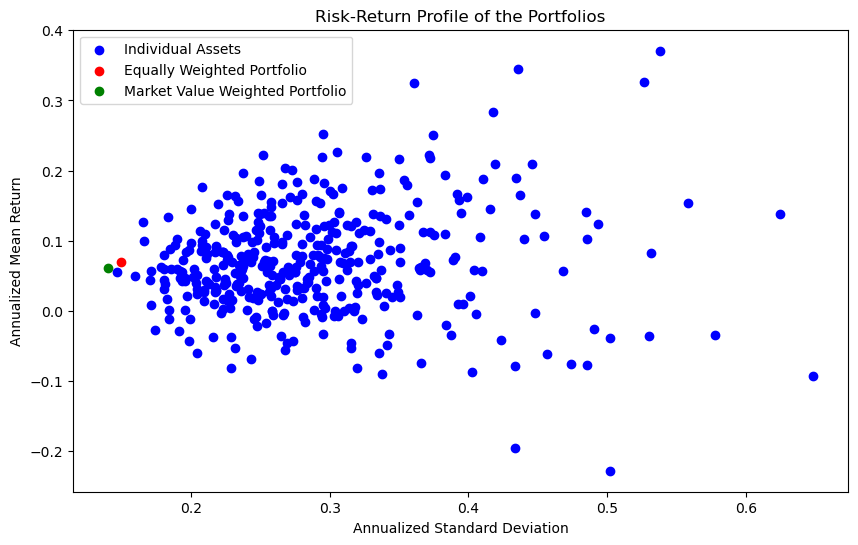

In [45]:
# Define the list of delisted companies
delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
			'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
			'CSR DEAD - DEAD.10/07/24', 
			'J S R DEAD - DELIST.25/06/24',
			'LAWSON DEAD - DELIST.24/07/24',
			'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
			'TOSHIBA DEAD - DELIST.20/12/23']

plt.figure(figsize=(10, 6))
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
#plt.scatter(annualization[annualization['Name'].isin(delisted)]['annualized_std'], annualization[annualization['Name'].isin(delisted)]['annualized_mean'], color='cyan')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.savefig('riskreturn.png')
plt.show()

# **Exercise 3**

In [46]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')
# Merging the datasets
df_ex3 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex3.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex3 = pd.merge(df_ex3, static, on=['Name', 'ISIN'], how='outer')
# Filter region and years of interest
df_ex3 = df_ex3[df_ex3['Region'] == 'PAC']
df_ex3 = df_ex3[(df_ex3['year'] >= '2012-12-31') & (df_ex3['year'] <= '2023-12-31')]


In [47]:
# Filter df_ex3 to the same companies of interest as before (non missing escore from 2013 to 2024)
df_ex3 = df_ex3[df_ex3['ISIN'].isin(interest_companies)]

In [48]:
# Ensure the 'year' column in escore is datetime type
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')

# Merge the dataframes using merge_asof to align yearly escore data with monthly df_ex3 data
df_ex3 = pd.merge_asof(df_ex3.sort_values('year'), 
                                melted_escore.sort_values('year'), 
                                by=['Name', 'ISIN'], 
                                on='year', 
                                direction='backward')

In [49]:
# Returns percentage change and drop the 31.12.2012 rows
df_ex3['pct_monthly_return'] = df_ex3.groupby('Name')['monthly_return'].pct_change()
df_ex3 = df_ex3[pd.to_datetime(df_ex3['year']).dt.year >= 2013]

In [50]:
df_ex3.sort_values(by=['Name', 'year'], inplace=True)

In [51]:
df_ex3 = df_ex3[(df_ex3['year'].dt.year != 2013) & (df_ex3['year'].dt.year != 2012)]

In [52]:
df_ex3[df_ex3['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,escore,pct_monthly_return
52914,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,63.93,0.0
53307,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,63.93,0.0
53701,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,63.93,0.0
54106,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,63.93,0.0
54362,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,89.52,0.0


In [53]:
# Individual handling of the 5 missings
df_ex3['pct_monthly_return'].loc[52914] = -1.
df_ex3['pct_monthly_return'].loc[53307] = np.nan
df_ex3['pct_monthly_return'].loc[53701] = np.nan
df_ex3['pct_monthly_return'].loc[54106] = np.nan
df_ex3['pct_monthly_return'].loc[54362] = -1.


In [54]:
# Create the variance-covariance matrix for pct_monthly_return
cov_matrix = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

In [55]:
# Install scipy if not already installed
%pip install scipy

from scipy.optimize import minimize

Note: you may need to restart the kernel to use updated packages.


In [56]:
# Objective function: portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [57]:
# Number of assets
num_assets = len(cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
min_variance_weights = result.x

# Display the optimal weights
#min_variance_weights

In [58]:
minvar_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
minvar_pf['minvar_w'] = min_variance_weights
minvar_pf['annualized_mean'] = minvar_pf['pct_monthly_return'] * 12
minvar_pf['annualized_std'] = minvar_pf['pct_monthly_return'].std() * np.sqrt(12)
# Annualized mean
minvar_ann_ret = (minvar_pf['annualized_mean'] * minvar_pf['minvar_w']).sum()
# Annualized std
minvar_ann_std = minvar_pf['annualized_std'].std() * np.sqrt(12)

In [59]:
#min return
minvar_min_ret = minvar_pf['annualized_mean'].min()
#max return
minvar_max_ret = minvar_pf['annualized_mean'].max()
#minvar pf sharpe ratio
minvar_sharpe = (minvar_ann_ret - ann_rf)/ minvar_ann_std


In [60]:
# Objective function: negative portfolio return (to maximize return)
def portfolio_return(weights, returns):
    return -np.dot(weights, returns)

# Mean returns of the assets
mean_returns = df_ex3.groupby('Name')['pct_monthly_return'].mean().values

# Minimize the negative portfolio return
result_max_return = minimize(portfolio_return, init_guess, args=(mean_returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights for maximum return portfolio
max_return_weights = result_max_return.x

# Display the optimal weights
# max_return_weights

In [61]:
# Calculate the annualized return of the minimum variance portfolio
minvar_ann_ret = np.sum(min_variance_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
minvar_ann_std = np.sqrt(np.dot(min_variance_weights.T, np.dot(cov_matrix * 12, min_variance_weights)))

# Calculate the annualized return of the minimum variance portfolio
maxr_ann_ret = np.sum(max_return_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
maxr_ann_std = np.sqrt(np.dot(max_return_weights.T, np.dot(cov_matrix * 12, max_return_weights)))


In [62]:
maxr_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
maxr_pf['maxr_w'] = max_return_weights
maxr_pf['annualized_mean'] = maxr_pf['pct_monthly_return'] * 12
maxr_pf['annualized_std'] = maxr_pf['pct_monthly_return'].std() * np.sqrt(12)

In [63]:
#min return
maxr_min_ret = maxr_pf['annualized_mean'].min()
#max return
maxr_max_ret = maxr_pf['annualized_mean'].max()
#minvar pf sharpe ratio
maxr_sharpe = (maxr_ann_ret - ann_rf)/ maxr_ann_std

In [64]:
statistics = pd.DataFrame({'Portfolio': ['Minimum Variance Portfolio', 'Maximum Return Portfolio'],
                           'Annualized Return': [minvar_ann_ret, maxr_ann_ret],
                           'Annualized Standard Deviation': [minvar_ann_std, maxr_ann_std],
                           'Sharpe Ratio': [minvar_sharpe, maxr_sharpe],
                           'Min Return': [minvar_min_ret, maxr_min_ret],
                           'Max Return': [minvar_max_ret, maxr_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Minimum Variance Portfolio,0.052046,0.079459,2.396715e+14,-0.228193,0.370925
1,Maximum Return Portfolio,0.370925,0.538206,6.675044e-01,-0.228193,0.370925


In [65]:
# Compute the efficient frontier portofolios
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, 5)
efficient_frontier = []
for target in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12 - target})
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_frontier.append(result.x)

In [66]:
# Calculate the annualized return and standard deviation for each set of weights in the efficient frontier
target_ann_ret = []
target_ann_std = []

for weights in efficient_frontier:
	ann_ret = np.sum(weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12
	ann_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
	target_ann_ret.append(ann_ret)
	target_ann_std.append(ann_std)

# Convert lists to numpy arrays
target_ann_ret = np.array(target_ann_ret)
target_ann_std = np.array(target_ann_std)

In [67]:
monthly_rf = risk_free['RF'].mean() / 100 # professor said it in the mail
ann_rf = monthly_rf * 12  # professor explicitly defined annualization as simple multiplication

# Annualized returns and covariance
mean_returns_monthly = df_ex3.groupby('Name')['pct_monthly_return'].mean()
cov_matrix_monthly = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

mean_returns_annual = mean_returns_monthly * 12
cov_matrix_annual = cov_matrix_monthly * 12

num_assets = len(mean_returns_annual)

# Optimization constraints and bounds
init_guess = np.ones(num_assets) / num_assets
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Minimum Variance Portfolio
res_minvar = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
minvar_weights = res_minvar.x
minvar_ann_ret = np.dot(minvar_weights, mean_returns_annual)
minvar_ann_std = np.sqrt(portfolio_variance(minvar_weights, cov_matrix_annual))

# Define the negative portfolio return function
def negative_portfolio_return(weights, mean_returns):
    return -np.sum(weights * mean_returns)

# Maximum Return Portfolio
res_maxret = minimize(negative_portfolio_return, init_guess, args=(mean_returns_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
maxr_weights = res_maxret.x
maxr_ann_ret = np.sum(maxr_weights * mean_returns_annual)
maxr_ann_std = np.sqrt(np.dot(maxr_weights.T, np.dot(cov_matrix_annual, maxr_weights)))

# Efficient frontier
n_portfolios = 5
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, n_portfolios)
efficient_frontier_std, efficient_frontier_ret = [], []

for target in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(x * mean_returns_annual) - target}
    )
    res_ef = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints_ef)
    w_opt = res_ef.x
    efficient_frontier_std.append(np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix_annual, w_opt))))
    efficient_frontier_ret.append(target)

# Define the negative Sharpe ratio function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Tangency portfolio (maximum Sharpe ratio)
res_tan = minimize(negative_sharpe_ratio, init_guess,
                   args=(mean_returns_annual, cov_matrix_annual, ann_rf),
                   method='SLSQP', bounds=bounds, constraints=constraints)

tan_weights = res_tan.x
tan_ret = np.dot(tan_weights, mean_returns_annual)
tan_vol = np.sqrt(np.dot(tan_weights.T, np.dot(cov_matrix_annual, tan_weights)))


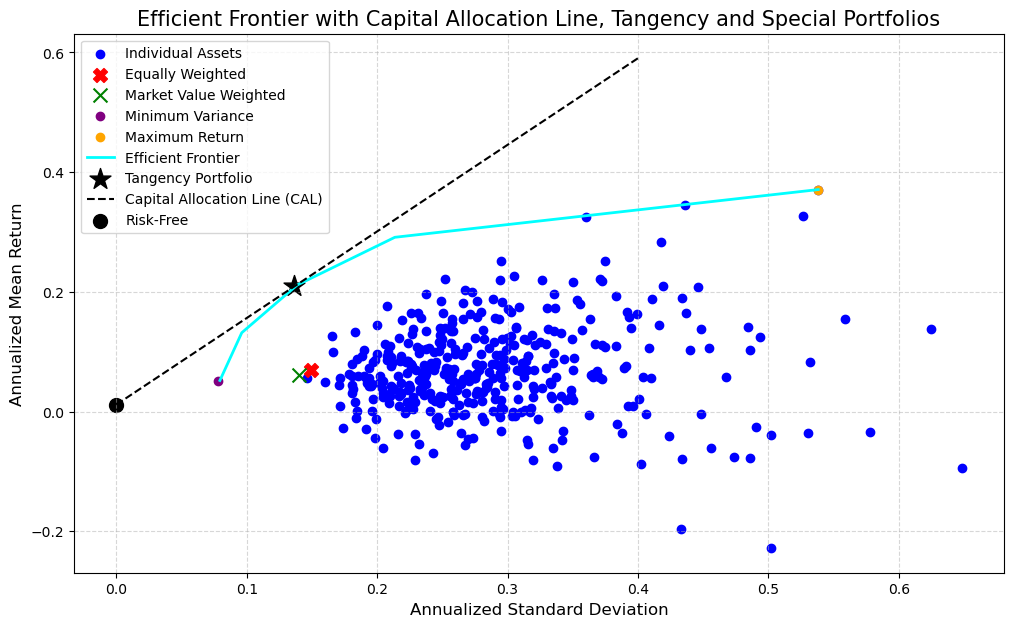

In [68]:

# Final comprehensive plot
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')

# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=250, label='Tangency Portfolio')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, 0.4, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [207]:
max_return_weights.max()

1.0

In [69]:
# Compute ex-post returns for each portfolio along the efficient frontier
ex_post_returns = []

for i in efficient_frontier:
    monthly_returns = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return')
    portfolio_returns = monthly_returns.dot(i)
    ex_post_returns.append(portfolio_returns)

# Calculate ex-post annualized average return, annualized volatility, and Sharpe ratio
ex_post_ann_ret = []
ex_post_ann_std = []
ex_post_sharpe = []

for returns in ex_post_returns:
    ann_ret = returns.mean() * 12
    ann_std = returns.std() * np.sqrt(12)
    sharpe_ratio = (ann_ret - ann_rf) / ann_std
    ex_post_ann_ret.append(ann_ret)
    ex_post_ann_std.append(ann_std)
    ex_post_sharpe.append(sharpe_ratio)

# Find the portfolio with the highest ex-ante and ex-post Sharpe ratio
max_ex_ante_sharpe_idx = np.argmax(target_ann_ret / target_ann_std)
max_ex_post_sharpe_idx = np.argmax(ex_post_sharpe)

'''# Plot the efficient frontier, individual assets, capital allocation line, and portfolios
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')
# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, 0.4, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')
#Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=150, label='Tangency Portfolio')


# Highlight the portfolios with the highest ex-ante and ex-post Sharpe ratio
plt.scatter(target_ann_std[max_ex_ante_sharpe_idx], target_ann_ret[max_ex_ante_sharpe_idx], color='brown', s=40, label='Max Ex-Ante Sharpe Ratio')
plt.scatter(ex_post_ann_std[max_ex_post_sharpe_idx], ex_post_ann_ret[max_ex_post_sharpe_idx], color='indigo', s=40, label='Max Ex-Post Sharpe Ratio')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()'''

# Print the performance metrics
print(f"Portfolio with highest ex-ante Sharpe ratio: {max_ex_ante_sharpe_idx}")
print(f"Ex-Ante Sharpe Ratio: {target_ann_ret[max_ex_ante_sharpe_idx] / target_ann_std[max_ex_ante_sharpe_idx]}")
print(f"Ex-Post Sharpe Ratio: {ex_post_sharpe[max_ex_ante_sharpe_idx]}")

print(f"Portfolio with highest ex-post Sharpe ratio: {max_ex_post_sharpe_idx}")
print(f"Ex-Ante Sharpe Ratio: {target_ann_ret[max_ex_post_sharpe_idx] / target_ann_std[max_ex_post_sharpe_idx]}")
print(f"Ex-Post Sharpe Ratio: {ex_post_sharpe[max_ex_post_sharpe_idx]}")

Portfolio with highest ex-ante Sharpe ratio: 2
Ex-Ante Sharpe Ratio: 1.5247924670294977
Ex-Post Sharpe Ratio: 1.4046550502985797
Portfolio with highest ex-post Sharpe ratio: 2
Ex-Ante Sharpe Ratio: 1.5247924670294977
Ex-Post Sharpe Ratio: 1.4046550502985797


# **Exercise 4**

In [70]:
# Setting df for ex 4 with the same companies as before
df_ex4 = pd.merge(monthly_return_melted, static, how='outer')
df_ex4 = df_ex4[df_ex4['Region'] == 'PAC']
df_ex4 = df_ex4[df_ex4['ISIN'].isin(interest_companies)]
df_ex4['year'] = pd.to_datetime(df_ex4['year'])

In [71]:
# Filtering by the interesting timeframe
df_ex4 = df_ex4[(df_ex4['year'] >= '2003-12-01') & (df_ex4['year'] <= '2024-12-31')]

In [72]:
# Computing the individual returns
df_ex4['pct_monthly_return'] = df_ex4.groupby('Name')['monthly_return'].pct_change()

In [73]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
954,77 BANK,JP3352000008,2003-12-31,0.70,JP,PAC,NaN
955,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143
956,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303
957,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059
958,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462
...,...,...,...,...,...,...,...
770401,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717
770402,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326
770403,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572
770404,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543


In [74]:
# Drop December 2003
df_ex4 = df_ex4[df_ex4['year'] >= '2004-01-01']

In [75]:
df_ex4[df_ex4['monthly_return'].isna()]['Name'].unique()

array(['A2B AUSTRALIA DEAD - DELIST.12/04/24', 'AOZORA BANK',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24', 'CHINA MENGNIU DAIRY',
       'CLEANAWAY WASTE MANAGEMENT', 'CSR DEAD - DEAD.10/07/24', 'DENA',
       'ELEC.POWER DEV.', 'INPEX', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'LINK REAL ESTATE INVESTMENT TRUST', 'OTSUKA HOLDINGS',
       'PACIFIC BASIN SHIP.',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23', 'SEEK',
       'SOUTHERN CROSS MEDIA GROUP', 'SUMCO', 'T & D HOLDINGS',
       'TOSHIBA DEAD - DELIST.20/12/23'], dtype=object)

In [76]:
# Individual handling of the 5 missings
'A2B AUSTRALIA DEAD - DELIST.12/04/24'
df_ex4['pct_monthly_return'].loc[2104] = -1.
df_ex4['pct_monthly_return'].loc[2105] = np.nan
df_ex4['pct_monthly_return'].loc[2106] = np.nan
df_ex4['pct_monthly_return'].loc[2107] = np.nan
df_ex4['pct_monthly_return'].loc[2108] = np.nan
df_ex4['pct_monthly_return'].loc[2109] = np.nan
df_ex4['pct_monthly_return'].loc[2110] = np.nan
df_ex4['pct_monthly_return'].loc[2111] = np.nan
df_ex4['pct_monthly_return'].loc[2112] = np.nan
'BENESSE HOLDINGS DEAD - DELIST.17/05/24'
df_ex4['pct_monthly_return'].loc[88477] = -1.
df_ex4['pct_monthly_return'].loc[88478] = np.nan
df_ex4['pct_monthly_return'].loc[88479] = np.nan
df_ex4['pct_monthly_return'].loc[88480] = np.nan
df_ex4['pct_monthly_return'].loc[88481] = np.nan
df_ex4['pct_monthly_return'].loc[88482] = np.nan
df_ex4['pct_monthly_return'].loc[88483] = np.nan
df_ex4['pct_monthly_return'].loc[88484] = np.nan
'CSR DEAD - DEAD.10/07/24'
df_ex4['pct_monthly_return'].loc[182401] = -1.
df_ex4['pct_monthly_return'].loc[182402] = np.nan
df_ex4['pct_monthly_return'].loc[182403] = np.nan
df_ex4['pct_monthly_return'].loc[182404] = np.nan
df_ex4['pct_monthly_return'].loc[182405] = np.nan
df_ex4['pct_monthly_return'].loc[182406] = np.nan
df_ex4['pct_monthly_return'].loc[182407] = np.nan
'J S R DEAD - DELIST.25/06/24'
df_ex4['pct_monthly_return'].loc[362998] = -1.
df_ex4['pct_monthly_return'].loc[362999] = np.nan
df_ex4['pct_monthly_return'].loc[363000] = np.nan
df_ex4['pct_monthly_return'].loc[363001] = np.nan
df_ex4['pct_monthly_return'].loc[363002] = np.nan
df_ex4['pct_monthly_return'].loc[363003] = np.nan
df_ex4['pct_monthly_return'].loc[363004] = np.nan
'LAWSON DEAD - DELIST.24/07/24'
df_ex4['pct_monthly_return'].loc[406186] = -1.
df_ex4['pct_monthly_return'].loc[406187] = np.nan
df_ex4['pct_monthly_return'].loc[406188] = np.nan
df_ex4['pct_monthly_return'].loc[406189] = np.nan
df_ex4['pct_monthly_return'].loc[406190] = np.nan
df_ex4['pct_monthly_return'].loc[406191] = np.nan
'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23'
df_ex4['pct_monthly_return'].loc[592512] = -1.
df_ex4['pct_monthly_return'].loc[592513] = np.nan
df_ex4['pct_monthly_return'].loc[592514] = np.nan
df_ex4['pct_monthly_return'].loc[592515] = np.nan
df_ex4['pct_monthly_return'].loc[592516] = np.nan
df_ex4['pct_monthly_return'].loc[592517] = np.nan
df_ex4['pct_monthly_return'].loc[592518] = np.nan
df_ex4['pct_monthly_return'].loc[592519] = np.nan
df_ex4['pct_monthly_return'].loc[592520] = np.nan
df_ex4['pct_monthly_return'].loc[592521] = np.nan
df_ex4['pct_monthly_return'].loc[592522] = np.nan
df_ex4['pct_monthly_return'].loc[592523] = np.nan
df_ex4['pct_monthly_return'].loc[592524] = np.nan
df_ex4['pct_monthly_return'].loc[592525] = np.nan
df_ex4['pct_monthly_return'].loc[592526] = np.nan
df_ex4['pct_monthly_return'].loc[592527] = np.nan
'TOSHIBA DEAD - DELIST.20/12/23'
df_ex4['pct_monthly_return'].loc[698819] = -1.
df_ex4['pct_monthly_return'].loc[698820] = np.nan
df_ex4['pct_monthly_return'].loc[698821] = np.nan
df_ex4['pct_monthly_return'].loc[698822] = np.nan
df_ex4['pct_monthly_return'].loc[698823] = np.nan
df_ex4['pct_monthly_return'].loc[698824] = np.nan
df_ex4['pct_monthly_return'].loc[698825] = np.nan
df_ex4['pct_monthly_return'].loc[698826] = np.nan
df_ex4['pct_monthly_return'].loc[698827] = np.nan
df_ex4['pct_monthly_return'].loc[698828] = np.nan
df_ex4['pct_monthly_return'].loc[698829] = np.nan
df_ex4['pct_monthly_return'].loc[698830] = np.nan
df_ex4['pct_monthly_return'].loc[698831] = np.nan


In [77]:
df_ex4[(df_ex4['Name'] == 'TOSHIBA DEAD - DELIST.20/12/23') & (df_ex4['monthly_return'].isna())]

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,JP,PAC,-1.0
698820,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-01-31,NaN,JP,PAC,NaN
698821,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-02-29,NaN,JP,PAC,NaN
698822,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-03-29,NaN,JP,PAC,NaN
698823,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-04-30,NaN,JP,PAC,NaN
698824,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-05-31,NaN,JP,PAC,NaN
698825,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-06-28,NaN,JP,PAC,NaN
698826,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-07-31,NaN,JP,PAC,NaN
698827,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-08-30,NaN,JP,PAC,NaN
698828,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-09-30,NaN,JP,PAC,NaN


In [78]:
'''# Initial pf comutuation (2004-2013)
df_ex4_initial = df_ex4[df_ex4['year'] <= '2014-01-01']'''

"# Initial pf comutuation (2004-2013)\ndf_ex4_initial = df_ex4[df_ex4['year'] <= '2014-01-01']"

In [79]:
'''# Variance-covariance initial matrix
initial_cov_matrix = df_ex4_initial.pivot(index='year', columns='Name', values='pct_monthly_return').cov()'''

"# Variance-covariance initial matrix\ninitial_cov_matrix = df_ex4_initial.pivot(index='year', columns='Name', values='pct_monthly_return').cov()"

In [80]:
'''# Number of assets
num_assets = len(initial_cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
initial_pf = minimize(portfolio_variance, init_guess, args=(initial_cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
initial_weights = initial_pf.x

# Display the optimal weights
#min_variance_weights'''

"# Number of assets\nnum_assets = len(initial_cov_matrix)\n\n# Initial guess for the weights\ninit_guess = num_assets * [1. / num_assets]\n\n# Constraints: the sum of weights is 1\nconstraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n\n# Bounds: weights can only be between 0 and 1\nbounds = tuple((0, 1) for asset in range(num_assets))\n\n# Minimize the portfolio variance\ninitial_pf = minimize(portfolio_variance, init_guess, args=(initial_cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)\n\n# Optimal weights\ninitial_weights = initial_pf.x\n\n# Display the optimal weights\n#min_variance_weights"

In [81]:
'''# Calculate the annualized return of the minimum variance portfolio
initial_ann_ret = np.sum(initial_weights * df_ex4_initial.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
initial_ann_std = np.sqrt(np.dot(initial_weights.T, np.dot(initial_cov_matrix * 12, initial_weights)))'''

"# Calculate the annualized return of the minimum variance portfolio\ninitial_ann_ret = np.sum(initial_weights * df_ex4_initial.groupby('Name')['pct_monthly_return'].mean().values) * 12\n\n# Calculate the annualized standard deviation of the minimum variance portfolio\ninitial_ann_std = np.sqrt(np.dot(initial_weights.T, np.dot(initial_cov_matrix * 12, initial_weights)))"

In [82]:
'''# First reallocation (2004-2013 + 2014)
df_ex4_2014 = df_ex4[df_ex4['year'] <= '2015-01-01']'''

"# First reallocation (2004-2013 + 2014)\ndf_ex4_2014 = df_ex4[df_ex4['year'] <= '2015-01-01']"

In [83]:
'''# Variance-covariance 2014 matrix
cov_matrix_2014 = df_ex4_2014.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
cov_matrix_2014'''

"# Variance-covariance 2014 matrix\ncov_matrix_2014 = df_ex4_2014.pivot(index='year', columns='Name', values='pct_monthly_return').cov()\ncov_matrix_2014"

In [84]:
'''# Number of assets
num_assets = len(cov_matrix_2014)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
pf_2014 = minimize(portfolio_variance, init_guess, args=(cov_matrix_2014,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights_2014 = pf_2014.x

# Display the optimal weights
#min_variance_weights'''

"# Number of assets\nnum_assets = len(cov_matrix_2014)\n\n# Initial guess for the weights\ninit_guess = num_assets * [1. / num_assets]\n\n# Constraints: the sum of weights is 1\nconstraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n\n# Bounds: weights can only be between 0 and 1\nbounds = tuple((0, 1) for asset in range(num_assets))\n\n# Minimize the portfolio variance\npf_2014 = minimize(portfolio_variance, init_guess, args=(cov_matrix_2014,), method='SLSQP', bounds=bounds, constraints=constraints)\n\n# Optimal weights\nweights_2014 = pf_2014.x\n\n# Display the optimal weights\n#min_variance_weights"

In [85]:
weights = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = df_ex4[df_ex4['year'] <= f'{time}-01-01']
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(pf.x)



In [86]:
len(weights)

11

In [87]:
final_df = pd.DataFrame()

for year in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    actual_timeframe = df_ex4[df_ex4['year'].dt.year == year]
    names = pd.DataFrame(actual_timeframe['Name'].unique(), columns=['Name'])
    names['weight'] = weights[year-2014]
    merged = pd.merge(actual_timeframe, names, on='Name', how='outer')
    final_df = pd.concat([final_df, merged])


In [88]:
final_df['weighted_returns'] = final_df['pct_monthly_return'] * final_df['weight']

In [235]:
final_df

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,1.373113e-19,-4.038566e-21
1,77 BANK,JP3352000008,2014-02-28,0.62,JP,PAC,-0.060606,1.373113e-19,-8.321894e-21
2,77 BANK,JP3352000008,2014-03-31,0.64,JP,PAC,0.032258,1.373113e-19,4.429395e-21
3,77 BANK,JP3352000008,2014-04-30,0.64,JP,PAC,0.000000,1.373113e-19,0.000000e+00
4,77 BANK,JP3352000008,2014-05-30,0.68,JP,PAC,0.062500,1.373113e-19,8.581954e-21
...,...,...,...,...,...,...,...,...,...
4903,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,1.205301e-18,-2.202296e-19
4904,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,1.205301e-18,6.813879e-19
4905,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,1.205301e-18,4.769671e-20
4906,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,1.205301e-18,-1.452901e-19


In [89]:
reb_pf = final_df.groupby('year')['weighted_returns'].sum().reset_index()
reb_pf

,year,weighted_returns
0,2014-01-31,-0.029426
1,2014-02-28,0.038480
2,2014-03-31,0.002818
3,2014-04-30,-0.013110
4,2014-05-30,0.025891
...,...,...
127,2024-08-30,0.039012
128,2024-09-30,-0.001295
129,2024-10-31,-0.012843
130,2024-11-29,0.003443


In [90]:
# Statistics of interest Rebalanced Portfolio
# Annualized return
reb_ann_ret = reb_pf['weighted_returns'].mean() * 12
# Annualized std
reb_ann_std = reb_pf['weighted_returns'].std() * np.sqrt(12)
# Sharpe ratio
reb_sharpe = (reb_ann_ret - ann_rf)/ reb_ann_std
#min return
reb_min_ret = reb_pf['weighted_returns'].min()
#max return
reb_max_ret = reb_pf['weighted_returns'].max()


In [91]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted', 'Yearly Rebalanced'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret, reb_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std, reb_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe, reb_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret, reb_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret, reb_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069011,0.149373,0.383879,-0.136916,0.132389
1,Market Value Weighted,0.061567,0.140286,0.355680,-0.115458,0.135156
2,Yearly Rebalanced,0.049445,0.110769,0.341027,-0.095761,0.102114


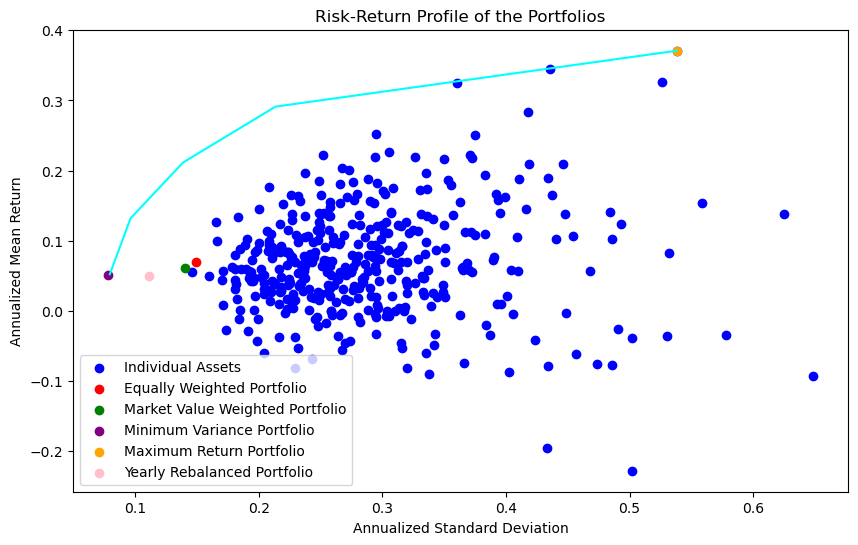

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(target_ann_std, target_ann_ret, color='cyan')
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance Portfolio')
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return Portfolio')
plt.scatter(reb_ann_std, reb_ann_ret, color='pink', label='Yearly Rebalanced Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.show()

In [93]:
# Install seaborn if not already installed
%pip install seaborn

import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


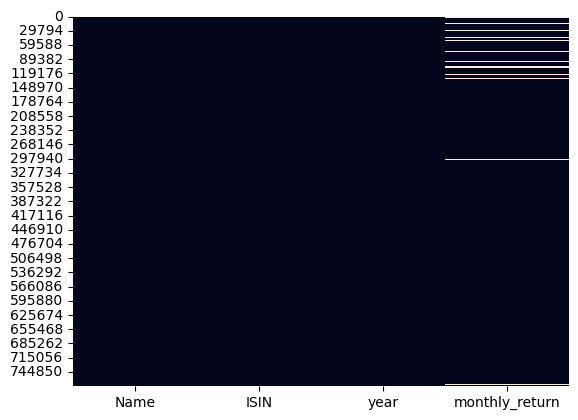

In [94]:
plt.figure()

sns.heatmap(monthly_return_melted.isnull(), cbar=False)
plt.show()


In [95]:
print('Done!')

Done!


# **_HOMEWORK 2_**

In [163]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
955,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143
483555,NIPPON ELEC.GLASS,JP3733400000,2004-01-30,10.49,JP,PAC,0.041708
649354,SUMITOMO HEAVY INDS.,JP3405400007,2004-01-30,1.96,JP,PAC,0.020833
166150,COMFORTDELGRO CORPORATION,SG1N31909426,2004-01-30,69.31,SG,PAC,0.124980
648750,SUMITOMO CHEMICAL,JP3401400001,2004-01-30,4.78,JP,PAC,0.004202
...,...,...,...,...,...,...,...
361192,ITOCHU,JP3143600009,2024-12-31,22.28,JP,PAC,0.013649
764063,YAMADA HOLDINGS,JP3939000000,2024-12-31,14.02,JP,PAC,-0.052703
665913,TAKARA HDG.,JP3459600007,2024-12-31,15.47,JP,PAC,0.005852
2112,A2B AUSTRALIA DEAD - DELIST.12/04/24,AU0000032187,2024-12-31,NaN,AU,PAC,NaN


In [164]:
monthly_return_melted['year'] = pd.to_datetime(monthly_return_melted['year'])
melted_escore['year'] = pd.to_datetime(melted_escore['year'])

# Sort by date before merging
df_ex4 = df_ex4.sort_values(by='year')
melted_escore = melted_escore.sort_values(by='year')

# Merge using closest past escore value
dfh2 = pd.merge_asof(
    df_ex4, 
    melted_escore, 
    on='year', 
    by=['Name', 'ISIN'], 
    direction='backward'  # Pick closest previous date
)

dfh2.head()


,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,NaN
1,GUNMA BANK,JP3276400003,2004-01-30,4.40,JP,PAC,-0.045553,NaN
2,LEE & MAN PAPER MNFG.,KYG5427W1309,2004-01-30,18.34,HK,PAC,0.088427,NaN
3,MITSUBISHI HEAVY INDS.,JP3900000005,2004-01-30,2.22,JP,PAC,0.057143,34.66
4,MATSUKIYOKARA,JP3869010003,2004-01-30,2.54,JP,PAC,0.170507,NaN


In [165]:
dfh2.sort_values(by=['Name', 'year'], inplace=True)

In [166]:
dfh2

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,NaN
712,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303,NaN
1033,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059,NaN
1621,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462,NaN
1784,77 BANK,JP3352000008,2004-05-31,0.76,JP,PAC,0.013333,NaN
...,...,...,...,...,...,...,...,...
101362,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,81.68
101726,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,81.68
102121,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,81.68
102525,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,81.68


In [167]:
dfh2.shape

(103068, 8)

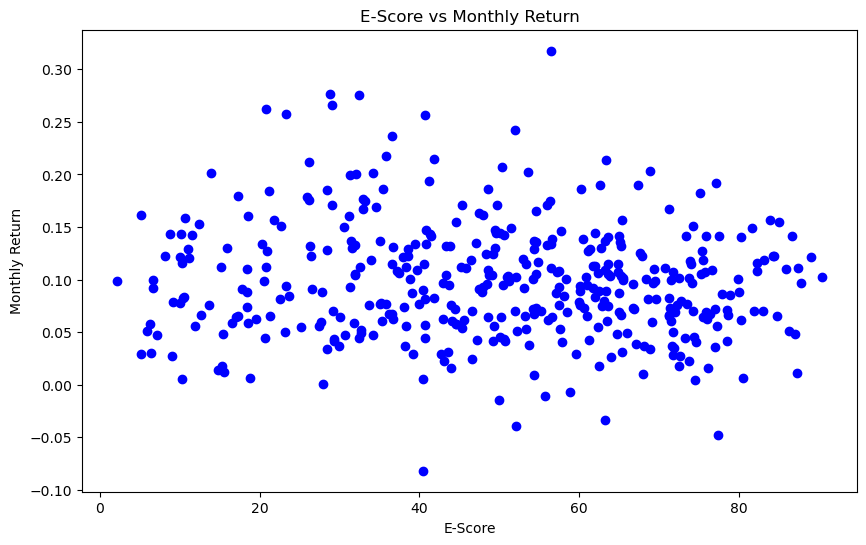

In [168]:
plt.figure(figsize=(10, 6))
plt.scatter(dfh2.groupby('Name')['escore'].mean(), dfh2.groupby('Name')['pct_monthly_return'].mean()*12, color='blue')
plt.xlabel('E-Score')
plt.ylabel('Monthly Return')
plt.title('E-Score vs Monthly Return')
plt.show()

In [169]:
dfh2['year_only'] = dfh2['year'].dt.year

In [170]:
dfh2 = dfh2[(dfh2['year_only'] >= 2013) & (dfh2['year_only'] <= 2023)]

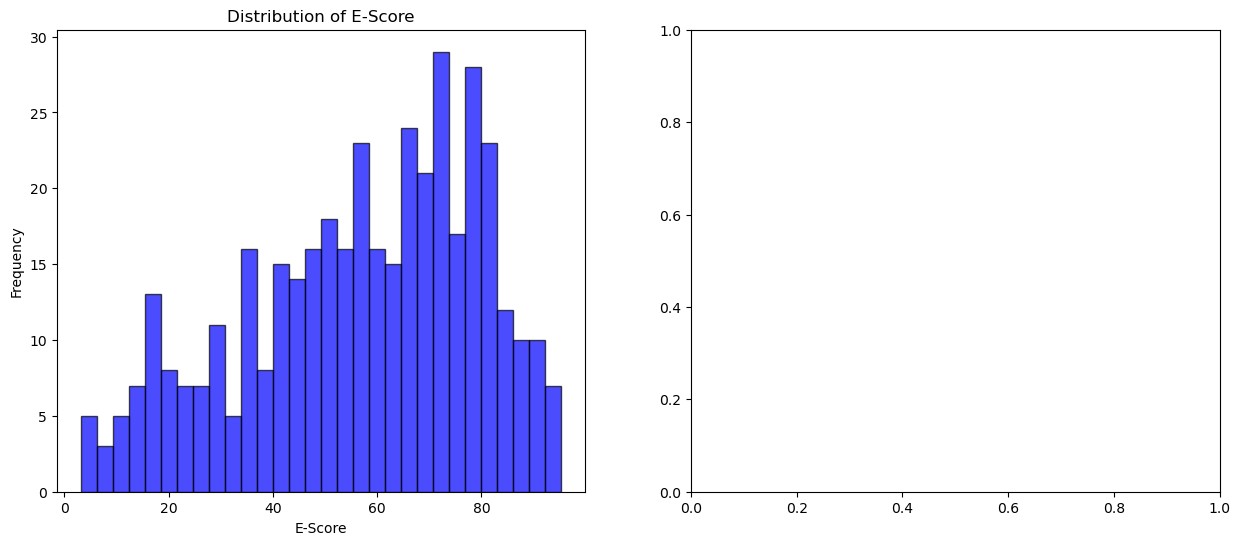

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].hist(dfh2.groupby('Name')['escore'].mean(), bins=30, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_xlabel('E-Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of E-Score')

#axs[1].hist(dfh2.groupby('year_only')['escore'].mean(), bins=30, color='red', alpha=0.7, edgecolor='black')
plt.show()

In [172]:
dfh2[dfh2['Name'] == '77 BANK'].tail(15)

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only
92259,77 BANK,JP3352000008,2022-10-31,0.43,JP,PAC,-0.022727,61.36,2022
92694,77 BANK,JP3352000008,2022-11-30,0.50,JP,PAC,0.162791,61.36,2022
92894,77 BANK,JP3352000008,2022-12-30,0.60,JP,PAC,0.200000,61.36,2022
93456,77 BANK,JP3352000008,2023-01-31,0.63,JP,PAC,0.050000,60.34,2023
93746,77 BANK,JP3352000008,2023-02-28,0.63,JP,PAC,0.000000,60.34,2023
94449,77 BANK,JP3352000008,2023-03-31,0.59,JP,PAC,-0.063492,60.34,2023
94835,77 BANK,JP3352000008,2023-04-28,0.59,JP,PAC,0.000000,60.34,2023
94903,77 BANK,JP3352000008,2023-05-31,0.64,JP,PAC,0.084746,60.34,2023
95649,77 BANK,JP3352000008,2023-06-30,0.65,JP,PAC,0.015625,60.34,2023
95917,77 BANK,JP3352000008,2023-07-31,0.78,JP,PAC,0.200000,60.34,2023


In [173]:
dfh2.groupby('Name')['escore'].mean()

Name
77 BANK                                 30.783636
A2B AUSTRALIA DEAD - DELIST.12/04/24    16.228182
ACOM                                    24.194545
ADVANTEST                               83.044545
AEON                                    84.964545
                                          ...    
YAMAHA                                  59.066364
YAMATO HDG.                             43.613636
YOKOGAWA ELECTRIC                       79.676364
YUE YUEN INDL.HDG.                      28.368182
YUEXIU PROPERTY COMPANY                 67.039091
Name: escore, Length: 409, dtype: float64

In [174]:
dftest = dfh2.groupby('year_only')['escore'].mean().reset_index()
dftest

,year_only,escore
0,2013,46.373594
1,2014,47.251320
2,2015,49.710831
3,2016,52.625428
4,2017,54.382200
5,2018,57.039389
6,2019,60.218826
7,2020,62.384719
8,2021,64.344670
9,2022,65.424303


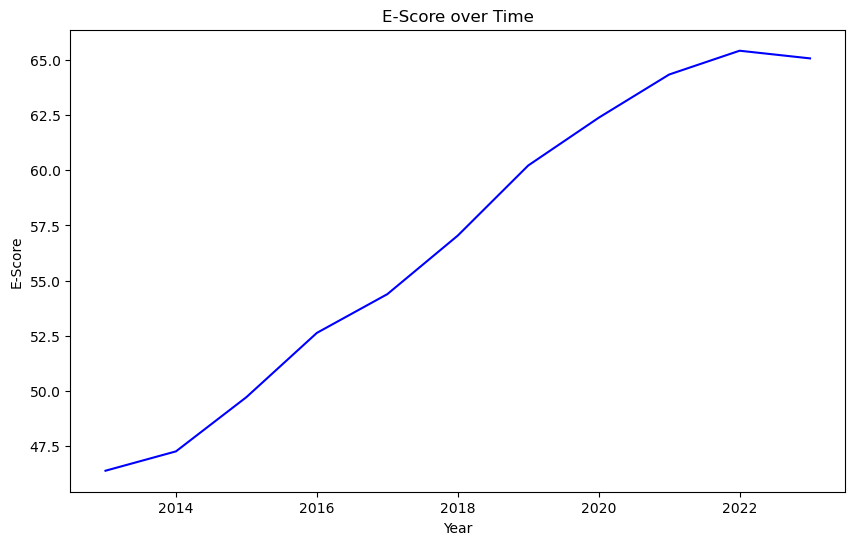

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(dftest['year_only'], dftest['escore'], color='blue')
plt.xlabel('Year')
plt.ylabel('E-Score')
plt.title('E-Score over Time')
plt.show()

In [177]:
dfh2.describe()

,year,monthly_return,pct_monthly_return,escore,year_only
count,53988,53983.000000,53985.000000,53988.000000,53988.000000
mean,2018-07-15 13:27:16.363636480,1247.507879,0.006881,56.802892,2018.000000
min,2013-01-31 00:00:00,0.030000,-1.000000,0.000000,2013.000000
25%,2015-10-22 12:00:00,4.690000,-0.042373,40.070000,2015.000000
50%,2018-07-15 00:00:00,16.910000,0.004717,61.730000,2018.000000
75%,2021-04-07 12:00:00,245.955000,0.053571,77.230000,2021.000000
max,2023-12-29 00:00:00,50224.400000,1.667961,98.210000,2023.000000
std,NaN,4306.188231,0.086467,25.363727,3.162307


## Exercise 2

In [178]:
efficient_frontier

array([[0.00000000e+00, 1.91099678e-18, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.74139012e-19, 2.10295818e-19, 2.47325912e-18, ...,
        0.00000000e+00, 1.00993389e-19, 7.79664333e-19],
       [2.56099882e-19, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.45103096e-18],
       [7.48393109e-18, 0.00000000e+00, 1.06933347e-17, ...,
        1.44933279e-18, 6.54774923e-18, 0.00000000e+00],
       [6.00117828e-16, 0.00000000e+00, 0.00000000e+00, ...,
        2.06458391e-16, 8.40692733e-16, 0.00000000e+00]])

In [179]:
dfh2_ex2 = dfh2[(dfh2['year'] >= '2014-01-01') & (dfh2['year'] <= '2023-12-31')]
dfh2_ex2.shape

(49080, 9)

In [180]:
df_ex3.shape

(49080, 9)

In [152]:
# Precompute the mean returns and the annualized mean returns
h2_ann_returns = (dfh2_ex2.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Define the constraints function
def constraints(target):
    return [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.sum(x * h2_ann_returns) - target}]

# Compute the efficient frontier portfolios
h2_target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, 5)
efficient_frontier = []

for target in target_returns:
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints(target))
    efficient_frontier.append(result.x)

# Convert the efficient frontier to a NumPy array for further processing if needed
efficient_frontier = np.array(efficient_frontier)

In [181]:
# Calculate the annualized return and standard deviation for each set of weights in the efficient frontier
h2_target_ann_ret = []
h2_target_escore = []

for w in efficient_frontier:
	target_ann_ret = np.sum(w * dfh2_ex2.groupby('Name')['pct_monthly_return'].mean().values)*12
	target_escore = np.sum(w * dfh2_ex2.groupby('Name')['escore'].mean().values)
	h2_target_ann_ret.append(target_ann_ret)
	h2_target_escore.append(target_escore)

# Convert lists to numpy arrays
h2_target_ann_ret = np.array(h2_target_ann_ret)
h2_target_escore = np.array(h2_target_escore)

In [182]:
h2_target_ann_ret

array([0.0512406 , 0.13116173, 0.21108286, 0.29100399, 0.37092513])

In [183]:
efficient_frontier

array([[0.00000000e+00, 1.91099678e-18, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.74139012e-19, 2.10295818e-19, 2.47325912e-18, ...,
        0.00000000e+00, 1.00993389e-19, 7.79664333e-19],
       [2.56099882e-19, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.45103096e-18],
       [7.48393109e-18, 0.00000000e+00, 1.06933347e-17, ...,
        1.44933279e-18, 6.54774923e-18, 0.00000000e+00],
       [6.00117828e-16, 0.00000000e+00, 0.00000000e+00, ...,
        2.06458391e-16, 8.40692733e-16, 0.00000000e+00]])

In [184]:
w_dfh2_ex2 = dfh2_ex2.groupby('Name')[['pct_monthly_return', 'escore']].mean().reset_index()

In [185]:
efficient_score = []
efficient_return = []
for i in range(len(efficient_frontier)):
    w_dfh2_ex2[f'weight_{i}'] = efficient_frontier[i]
    w_dfh2_ex2[f'w_escore_{i}'] = w_dfh2_ex2[f'weight_{i}'] * w_dfh2_ex2['escore']
    w_dfh2_ex2[f'w_return_{i}'] = w_dfh2_ex2[f'weight_{i}'] * w_dfh2_ex2['pct_monthly_return'] * 12
    efficient_score.append(w_dfh2_ex2[f'w_escore_{i}'].sum())
    efficient_return.append(w_dfh2_ex2[f'w_return_{i}'].sum())
    print(f'Portfolio {i+1} E-Score: {np.round(w_dfh2_ex2[f"w_escore_{i}"].sum(),2)} Return: {np.round(w_dfh2_ex2[f"w_return_{i}"].sum(),2)}')

Portfolio 1 E-Score: 61.89 Return: 0.05
Portfolio 2 E-Score: 56.44 Return: 0.13
Portfolio 3 E-Score: 55.67 Return: 0.21
Portfolio 4 E-Score: 62.87 Return: 0.29
Portfolio 5 E-Score: 75.5 Return: 0.37


In [186]:
efficient_score

[61.89427762218427,
 56.440093215400914,
 55.66543626043449,
 62.87367809089274,
 75.4970000018577]

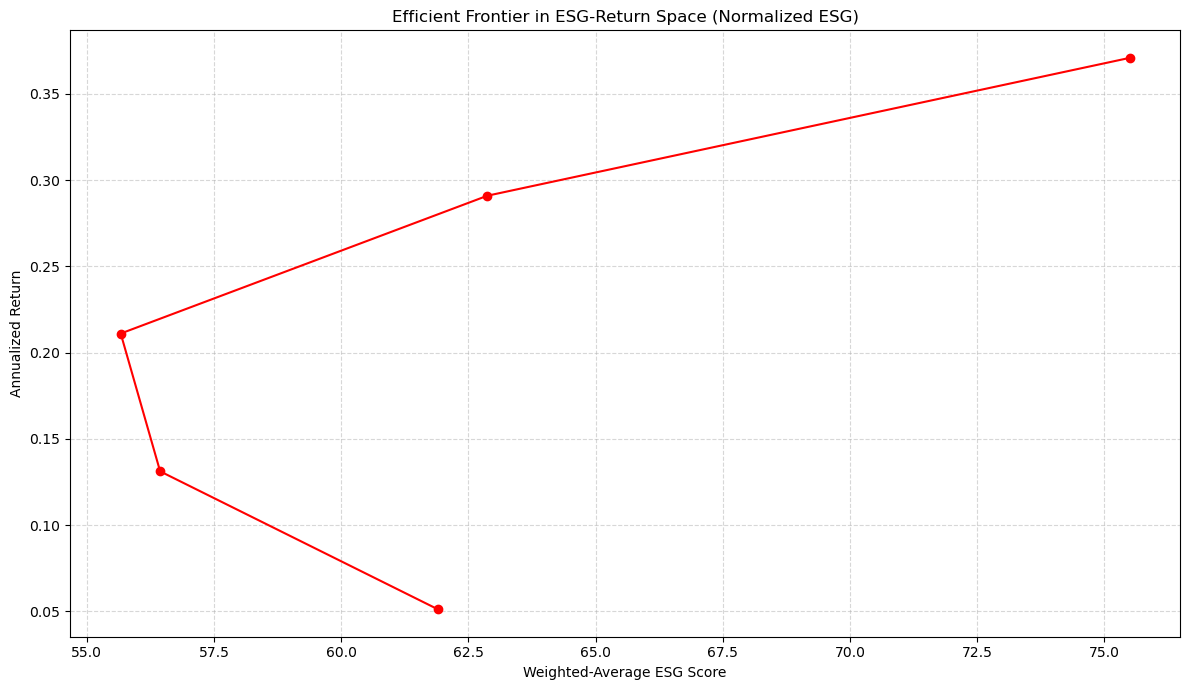

In [208]:
# Plotting
plt.figure(figsize=(12, 7))
plt.plot(efficient_score, efficient_return, marker='o', linestyle='-', color='red')
#plt.scatter(w_dfh2_ex2['escore'], w_dfh2_ex2['pct_monthly_return']*12, color='blue', label='Individual Assets')
plt.xlabel('Weighted-Average ESG Score')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier in ESG-Return Space (Normalized ESG)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [187]:
dfh2_ex2.groupby(['Name', 'ISIN'])['escore'].mean().reset_index().sort_values(by='escore', ascending=True).head(10)

,Name,ISIN,escore
360,TAKASHIMAYA,JP3456000003,3.448
335,SQUARE ENIX HOLDINGS,JP3164630000,3.524
173,KEIO,JP3277800003,3.752
244,NIPPON TELEVISION HDG.,JP3732200005,5.923
333,SOUTHERN CROSS MEDIA GROUP,AU000000SXL4,6.150
87,DENA,JP3548610009,7.097
261,ODAKYU ELECTRIC RY.,JP3196000008,7.369
393,USS,JP3944130008,9.472
362,TBS HOLDINGS,JP3588600001,10.517
293,SANKYO,JP3326410002,11.346


In [230]:
w_dfh2_ex2.sort_values(by=['weight_0', 'escore'], ascending=[False,  True]).head(10)

,Name,pct_monthly_return,escore,weight_0,w_escore_0,w_return_0,weight_1,w_escore_1,w_return_1,weight_2,w_escore_2,w_return_2,weight_3,w_escore_3,w_return_3,weight_4,w_escore_4,w_return_4
65,CLP HOLDINGS,0.004636,85.881,0.166523,14.301176,0.009263,1.217659e-01,1.045738e+01,6.773362e-03,2.462029e-02,2.114415e+00,1.369531e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
282,POWER ASSETS HOLDINGS,0.005006,42.823,0.106854,4.575824,0.006419,9.967519e-02,4.268391e+00,5.987595e-03,2.570685e-02,1.100844e+00,1.544238e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
191,LAWSON DEAD - DELIST.24/07/24,0.000714,67.126,0.091870,6.166877,0.000788,7.144378e-03,4.795735e-01,6.125051e-05,3.342825e-18,2.243905e-16,2.865886e-20,7.999254e-18,5.369579e-16,6.857956e-20,1.611120e-15,1.081480e-13,1.381253e-17
374,TOKYO GAS,0.002578,77.282,0.075530,5.837123,0.002337,2.137322e-02,1.651765e+00,6.611840e-04,1.228747e-18,9.496003e-17,3.801149e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
275,OSAKA GAS,0.003692,76.067,0.048463,3.686470,0.002147,1.408430e-02,1.071350e+00,6.240357e-04,0.000000e+00,0.000000e+00,0.000000e+00,9.231159e-18,7.021866e-16,4.090068e-19,4.842244e-16,3.683350e-14,2.145463e-17
395,WACOAL HDG.,0.004912,36.435,0.046502,1.694292,0.002741,3.017932e-02,1.099583e+00,1.778763e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
123,HANG SENG BANK,0.002573,87.554,0.040506,3.546503,0.001251,2.419868e-18,2.118691e-16,7.471085e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
179,KINTETSU GROUP HDG.,0.001360,16.699,0.038163,0.637283,0.000623,0.000000e+00,0.000000e+00,0.000000e+00,3.019928e-18,5.042978e-17,4.929181e-20,6.053885e-18,1.010938e-16,9.881259e-20,0.000000e+00,0.000000e+00,0.000000e+00
38,CANON MARKETING JAPAN,0.010811,23.841,0.035603,0.848814,0.004619,6.256014e-02,1.491496e+00,8.115698e-03,3.806041e-02,9.073983e-01,4.937438e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
338,SUBARU,0.001494,77.386,0.035178,2.722281,0.000631,1.125939e-18,8.713193e-17,2.018806e-20,0.000000e+00,0.000000e+00,0.000000e+00,1.362645e-17,1.054497e-15,2.443219e-19,0.000000e+00,0.000000e+00,0.000000e+00


In [188]:
dfh2_ex2.groupby(['Name', 'ISIN'])['escore'].mean().reset_index().sort_values(by='escore', ascending=False).head(10)

,Name,ISIN,escore
303,SEKISUI CHEMICAL,JP3419400001,95.771
132,HITACHI,JP3788600009,95.163
211,MITSUBISHI ELECTRIC,JP3902400005,94.279
106,FUJI ELECTRIC,JP3820000002,94.057
182,KOMATSU,JP3304200003,93.623
232,NATIONAL AUS.BANK,AU000000NAB4,93.520
68,COMMONWEALTH BK.OF AUS.,AU000000CBA7,92.564
378,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,92.382
398,WESTPAC BANKING,AU000000WBC1,91.445
209,MIRVAC GROUP STAPLED UNITS,AU000000MGR9,91.301


## Exercise 3

In [121]:
dfh2

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,NaN,2004
440,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303,NaN,2004
881,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059,NaN,2004
1365,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462,NaN,2004
2023,77 BANK,JP3352000008,2004-05-31,0.76,JP,PAC,0.013333,NaN,2004
...,...,...,...,...,...,...,...,...,...
101221,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,81.68,2024
101456,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,81.68,2024
101841,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,81.68,2024
102250,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,81.68,2024


In [122]:
dfh2_ex3 = dfh2.groupby('Name')[['pct_monthly_return', 'escore']].mean().reset_index()
for i in range(len(weights)):
    dfh2_ex3[f'weight_{2014+i}'] = weights[i]
    dfh2_ex3[f'w_escore_{2014+i}'] = dfh2_ex3[f'weight_{2014+i}'] * dfh2_ex3['escore']
    dfh2_ex3[f'w_return_{2014+i}'] = dfh2_ex3[f'weight_{2014+i}'] * dfh2_ex3['pct_monthly_return'] * 12
    efficient_score.append(dfh2_ex3[f'w_escore_{2014+i}'].sum())
    efficient_return.append(dfh2_ex3[f'w_return_{2014+i}'].sum())
    print(f'Portfolio {i+2014} E-Score: {np.round(dfh2_ex3[f"w_escore_{2014+i}"].sum(),2)} Return: {np.round(dfh2_ex3[f"w_return_{2014+i}"].sum(),2)}')

Portfolio 2014 E-Score: 49.38 Return: 0.08
Portfolio 2015 E-Score: 50.19 Return: 0.09
Portfolio 2016 E-Score: 49.35 Return: 0.09
Portfolio 2017 E-Score: 49.26 Return: 0.08
Portfolio 2018 E-Score: 48.66 Return: 0.08
Portfolio 2019 E-Score: 51.68 Return: 0.08
Portfolio 2020 E-Score: 50.73 Return: 0.08
Portfolio 2021 E-Score: 53.48 Return: 0.08
Portfolio 2022 E-Score: 52.37 Return: 0.08
Portfolio 2023 E-Score: 53.69 Return: 0.08
Portfolio 2024 E-Score: 53.97 Return: 0.08


In [123]:
dfh2_ex3.head()

,Name,pct_monthly_return,escore,weight_2014,w_escore_2014,w_return_2014,weight_2015,w_escore_2015,w_return_2015,weight_2016,...,w_return_2021,weight_2022,w_escore_2022,w_return_2022,weight_2023,w_escore_2023,w_return_2023,weight_2024,w_escore_2024,w_return_2024
0,77 BANK,0.004656,27.509000,1.373113e-19,3.777295e-18,7.672221e-21,3.146969e-18,8.656996e-17,1.758358e-19,0.000000e+00,...,0.000000e+00,4.975211e-19,1.368631e-17,2.779882e-20,3.842905e-19,1.057145e-17,2.147210e-20,9.581747e-20,2.635843e-18,5.353769e-21
1,A2B AUSTRALIA DEAD - DELIST.12/04/24,0.004002,15.370000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.841549e-19,...,5.340408e-20,1.572980e-18,2.417670e-17,7.554650e-20,0.000000e+00,0.000000e+00,0.000000e+00,1.631629e-19,2.507814e-18,7.836327e-21
2,ACOM,0.004148,23.182500,6.367048e-18,1.476041e-16,3.168947e-19,5.344585e-18,1.239008e-16,2.660056e-19,4.744006e-18,...,0.000000e+00,1.110810e-18,2.575135e-17,5.528618e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,ADVANTEST,0.015220,75.169048,0.000000e+00,0.000000e+00,0.000000e+00,1.058180e-18,7.954240e-17,1.932693e-19,2.078357e-18,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,AEON,0.005341,75.520476,1.492597e-18,1.127217e-16,9.567198e-20,0.000000e+00,0.000000e+00,0.000000e+00,6.811709e-19,...,0.000000e+00,2.372897e-18,1.792023e-16,1.520971e-19,1.523908e-18,1.150863e-16,9.767894e-20,0.000000e+00,0.000000e+00,0.000000e+00


In [236]:
dfh2_ex3['w_escore_2014'].sum()

49.378885619219886

In [124]:
h2e3_weights = []

In [125]:
constraints.append({'type': 'ineq', 'fun': lambda x: np.sum(weights * efficient_score) - 1.2 * np.sum(h2e3_weights * efficient_score)})


AttributeError: 'function' object has no attribute 'append'

In [ ]:
for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3[dfh2_ex3['year'] <= f'{time}-01-01']
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(pf.x)



In [261]:
final_df #From H1 ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,1.373113e-19,-4.038566e-21
1224,FAST RETAILING,JP3802300008,2014-01-31,34.83,JP,PAC,-0.094854,8.625109e-19,-8.181301e-20
756,CKI HOLDINGS,BMG2178K1009,2014-01-31,81.78,HK,PAC,-0.068777,6.147373e-02,-4.227982e-03
3708,SHIKOKU ELECTRIC POWER,JP3350800003,2014-01-31,9.41,JP,PAC,-0.022845,1.082322e-02,-2.472594e-04
2940,NIPPON TELG. & TEL.,JP3735400008,2014-01-31,0.65,JP,PAC,0.000000,1.537660e-18,0.000000e+00
...,...,...,...,...,...,...,...,...,...
1007,DAITO TST.CONSTRUCTION,JP3486800000,2024-12-31,5.55,JP,PAC,0.005435,5.190418e-18,2.820880e-20
587,CHINA MENGNIU DAIRY,KYG210961051,2024-12-31,111.85,HK,PAC,0.035936,1.326797e-18,4.767965e-20
1691,HOUSE SHOKUHIN GP.HONSHA K K,JP3765400001,2024-12-31,8.81,JP,PAC,-0.024363,5.746607e-18,-1.400059e-19
695,CHUBU ELEC.POWER,JP3526600006,2024-12-31,8.57,JP,PAC,-0.001166,0.000000e+00,-0.000000e+00


In [239]:
# Sort by date before merging
final_df = final_df.sort_values(by='year')
melted_escore = melted_escore.sort_values(by='year')

# Merge using closest past escore value
dfh2_ex3 = pd.merge_asof(
    final_df, 
    melted_escore, 
    on='year', 
    by=['Name', 'ISIN'], 
    direction='backward'  # Pick closest previous date
)

dfh2_ex3.head()


,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns,escore
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,1.373113e-19,-4.038566e-21,15.56
1,FAST RETAILING,JP3802300008,2014-01-31,34.83,JP,PAC,-0.094854,8.625109e-19,-8.181301e-20,49.03
2,CKI HOLDINGS,BMG2178K1009,2014-01-31,81.78,HK,PAC,-0.068777,6.147373e-02,-4.227982e-03,0.53
3,SHIKOKU ELECTRIC POWER,JP3350800003,2014-01-31,9.41,JP,PAC,-0.022845,1.082322e-02,-2.472594e-04,50.20
4,NIPPON TELG. & TEL.,JP3735400008,2014-01-31,0.65,JP,PAC,0.000000,1.537660e-18,0.000000e+00,79.69


In [245]:
dfh2_ex3['weighted_escore'] = dfh2_ex3['escore'] * dfh2_ex3['weight']

In [260]:
dftest = dfh2_ex3.groupby('year')['weighted_escore'].sum().reset_index()
dftest

,year,weighted_escore
0,2014-01-31,47.320810
1,2014-02-28,47.320810
2,2014-03-31,47.320810
3,2014-04-30,47.320810
4,2014-05-30,47.320810
...,...,...
127,2024-08-30,65.666049
128,2024-09-30,65.666049
129,2024-10-31,65.666049
130,2024-11-29,65.666049


In [256]:
gmv_ecore = dftest['weighted_escore'].mean()
gmv_ecore

58.613860498504536

In [257]:
target_ecore = 1.2 * gmv_ecore
target_ecore

70.33663259820544